In [36]:
#Implementing RCNN from scratch using torch and torchvision libaries
#Importing the required libraries
import torch
import torchvision # for datasets and models
import torchvision.transforms as transforms # for transforms
import torch.nn as nn # for neural networks
import torch.nn.functional as F # for neural networks
import torch.optim as optim # for optimizers
import torchmetrics # for metrics
from torchmetrics.classification.accuracy import Accuracy # for accuracy
from torchvision.models import EfficientNet # for efficientnet backbone
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np

import random
import os # for os related operations
import urllib # for downloading the dataset
import tarfile # for extracting the dataset
import xml.etree.ElementTree as ET # for parsing the xml files for annotations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Defining hyper parameters beforehand
config={'image_size':224, 'n_classes':21, 'bbox_reg': True, 'network': 'efficientnet-b0', 'max_proposals':2000, 'pad': 16}
train_config={'log_wandb':True, 'logging': ['plot'],
            'epochs': 3, 'batch_size':128, 'lr': 0.001, 'lr_decay':0.5, 'l2_reg': 1e-5}
train_config_classifer={'log_wandb':True, 'logging': ['plot'],
            'epochs': 1, 'batch_size':128, 'lr': 0.001, 'lr_decay':0.5, 'l2_reg': 1e-5}
voc_2012_classes=['background','Aeroplane',"Bicycle",'Bird',"Boat","Bottle","Bus","Car","Cat","Chair",'Cow',"Dining table","Dog","Horse","Motorbike",'Person', "Potted plant",'Sheep',"Sofa","Train","TV/monitor"]

In [5]:
# Load Data
# Create Directory if it is not yet created
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [24]:
class VOCDataset():
    def __init__(self):
        self.train_dir = None
        self.test_dir = None
        self.trainDataLink = None
        self.testDataLink = None
        
        self.common_init()

    # init that must be shared among all subclasses of this method
    def common_init(self):
        self.label_type=['none','aeroplane',"Bicycle",'bird',"Boat","Bottle","Bus","Car","Cat","Chair",'cow',"Diningtable","Dog","Horse","Motorbike",'person', "Pottedplant",'sheep',"Sofa","Train","TVmonitor"]
        self.convert_id=['background','Aeroplane',"Bicycle",'Bird',"Boat","Bottle","Bus","Car","Cat","Chair",'Cow',"Dining table","Dog","Horse","Motorbike",'Person', "Potted plant",'Sheep',"Sofa","Train","TV/monitor"]
        self.convert_labels={}
        for idx, x in enumerate(self.label_type):
            self.convert_labels[x.lower()]=idx

        self.num_classes=len(self.label_type) # 20 + 1(none)
    
    # download the dataset
    def download_dataset(self,validation_size=5000):
        """
        Downloads the dataset and extracts it
        """
        #print("[@] Downloading dataset [@]") 
        #print(self.trainDataLink) # print the link 
        #urllib.request.urlretrieve(self.trainDataLink, 'voctrain.tar') # type: ignore # download the dataset

        #print("[@] Extracting dataset [@]")
        tar = tarfile.open("voctrain.tar","r:") # open the tar file
        tar.extractall('/content/VOCtrain') # extract the tar file
        tar.close() # close the tar file
        #os.remove('content/voctrain.rar') # remove the tar file

        if self.testDataLink is None: 
            # Move 5k images to validation state
            print("[@] Moving 5k images to validation state [@]")
            ensure_dir(self.test_dir+'/Annotations/') # type: ignore # create the directory if it doesnt exist
            ensure_dir(self.test_dir+'/JPEGImages/') # type: ignore # create the directory if it doesnt exist

            random.seed(42) # set the seed
            print(len(os.listdir(self.train_dir+'/JPEGImages/'))) # print the number of images in the train directory
            val_images = random.sample(sorted(os.listdir(self.train_dir+'/JPEGImages/')),validation_size) # type: ignore # get the random images for validation set

            #for path in val_images:
             #   img_name = path.split('/')[-1].split('.')[0] # get the image name
                # move images
                #os.rename(self.train_dir+'/JPEGImages/'+img_name+'.jpg',self.test_dir+'/JPEGImages/'+img_name+'.jpg')  # type: ignore
                # move anotations
                #os.rename(self.train_dir+'/Annotations/'+img_name+'.xml',self.test_dir+'/Annotations/'+img_name+'.xml')  # type: ignore
        else:
            # Load the validation data
            print("[@] Downloading validation dataset [@]")
            urllib.request.urlretrieve(self.testDataLink, 'voctest.tar') # type: ignore # download the dataset

            print("[@] Extracting validation dataset [@]")
            tar = tarfile.open("voctest.tar","r:") # open the tar file
            tar.extractall('/content/VOCtest') # extract the tar file
            tar.close() # close the tar file
            os.remove('content/voctest.rar') # remove the tar file

    def read_xml(self,xml_path):
        """
        Read the xml file and return the data
        Args:
            xml_path: path to the xml file
        """
        object_list = [] 

        tree = ET.parse(open(xml_path,'r')) # parse the xml file
        root = tree.getroot() # get the root of the xml file

        objects = root.findall('object')
        for _object in objects:
            name = _object.find("name") # get the name of the object
            bndbox = _object.find("bndbox") # get the bounding box of the object
            # get the coordinates of the bounding box
            xmin = int(bndbox.find("xmin"))  # type: ignore
            ymin = int(bndbox.find("ymin"))  # type: ignore
            xmax = int(bndbox.find("xmax"))  # type: ignore
            ymax = int(bndbox.find("ymax"))  # type: ignore
            class_name = _object.find("name") # get the class name of the object
            object_list.append({'x1':xmin, 'x2':xmax, 'y1':ymin, 'y2':ymax, 'class':self.convert_labels[class_name]}) # append the object to the list
        return object_list # return the list of objects



In [25]:
class VOC2007(VOCDataset):
    # Class for the VOC2007 dataset
    def __init__(self):
        self.train_dir = '/content/VOCtrain/VOCdevkit/VOC2007'
        self.test_dir = '/content/VOCtest/VOCdevkit/VOC2007'
        self.trainDataLink = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
        self.testDataLink = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar'
        self.common_init()

class VOC2012(VOCDataset):
    # Class for the VOC2012 dataset
    def __init__(self):
        self.train_dir = '/content/VOCtrain/VOCdevkit/VOC2012'
        self.test_dir = '/content/VOCtest/VOCdevkit/VOC2012'
        self.trainDataLink = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
        self.testDataLink = None
        self.common_init()

In [26]:
voc_dataset=VOC2012() # create the dataset object
voc_dataset.download_dataset() # download the dataset

[@] Moving 5k images to validation state [@]
17125


In [27]:
val_datalen=len(os.listdir(voc_dataset.test_dir+'/Annotations'))
train_datalen=len(os.listdir(voc_dataset.train_dir+'/Annotations'))
print(train_datalen, val_datalen) # 17,125 total

17125 15000


In [28]:
def cv2_imshow(image,title="image"):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.show()

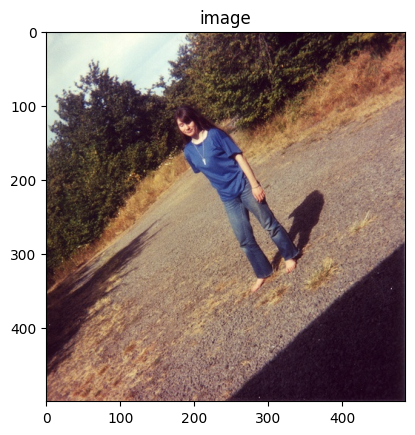

Shape: (500, 486, 3)


In [29]:

img_name = sorted(os.listdir(voc_dataset.train_dir+'/JPEGImages'))[0][:-4]

img=cv2.imread(voc_dataset.train_dir+'/JPEGImages/'+img_name+'.jpg')
cv2_imshow(img)
print('Shape:', img.shape)

w, h: 486 500


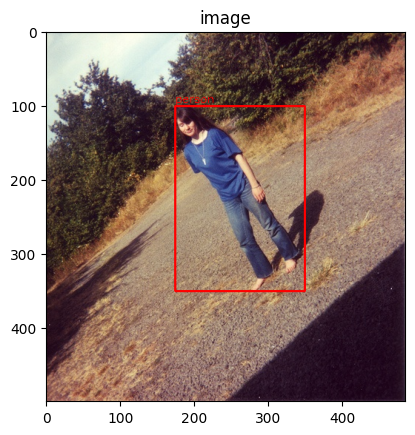

In [30]:
# referenced code of https://deepbaksuvision.github.io/Modu_ObjectDetection/posts/02_01_PASCAL_VOC.html
xml_path=voc_dataset.train_dir+'/Annotations/'+img_name+'.xml'
tree = ET.parse(open(xml_path, 'r'))

root=tree.getroot()
# print image shape
w, h = root.find("size").find("width").text, root.find("size").find("height").text
print('w, h:', w, h)

# plot bounding boxes
box_im=img.copy()
bbox_color=(0, 0, 255) # (b, g, r) not (r, g, b)
bbox_thickness=2

font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.5
fontColor              = bbox_color
lineType               = 1


objects = root.findall("object")
for _object in objects:
  name = _object.find("name").text
  bndbox = _object.find("bndbox")
  xmin = int(bndbox.find("xmin").text)
  ymin = int(bndbox.find("ymin").text)
  xmax = int(bndbox.find("xmax").text)
  ymax = int(bndbox.find("ymax").text)
  class_name = _object.find('name').text

  cv2.rectangle(box_im, (xmin, ymin), (xmax, ymax), bbox_color, bbox_thickness)
  cv2.putText(box_im, class_name, (xmin, ymin-5), font, 
    fontScale,
    fontColor,
    lineType)

cv2_imshow(box_im)

Found 1263 boxes...


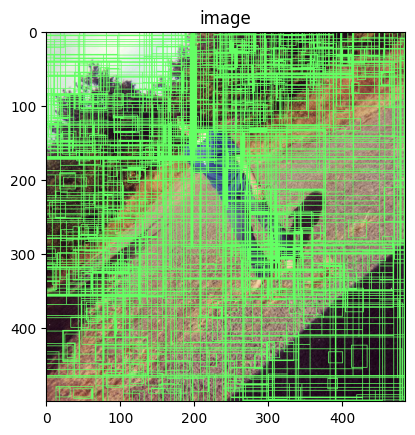

In [32]:
""" Demonstrating Selective Search Algorithm using opencv"""
img_ss=img.copy() # copy the image

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # create the selective search object
ss.setBaseImage(img_ss) # set the base image
ss.switchToSelectiveSearchFast() # "... extract around 2000 region proposals (we use selective search’s “fast mode” in all experiments)."
rects = ss.process()


print('Found',len(rects),'boxes...')
for i, rect in (enumerate(rects)):
    if i>2000:
        break
    x, y, w, h = rect
    cv2.rectangle(img_ss, (x, y), (x+w, y+h), (100, 255, 100), 1)
    
cv2_imshow(img_ss)

In [33]:
"""Helper functions for selective search and plotting results"""

def selective_search(image):
    """Perform selective search on the image and return the regions
    Parameters:
        image: the image to perform selective search on
    Returns:
        rects: the regions of interest
    """
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    return rects 

def plot_results(image, bboxes, color = (0,69,255)):
    """
    Plot the bounding boxes on the image
    Parameters:
        image: the image to plot on
        bboxes: the bounding boxes to plot
        color: the color of the bounding boxes
    
    Returns:
        image: the image with the bounding boxes plotted on it
    """
    plot_cfg = {
        'bbox_color': color, 'bbox_thickness': 2,
        'font': cv2.FONT_HERSHEY_SIMPLEX, 'font_scale': 0.5,
        'font_color': color, 'lineThickness': 1
    }
    img_ss = image.copy()
    for box in bboxes:
        bbox = box['bbox']
        cv2.rectangle(img_ss, (bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']), plot_cfg['bbox_color'], plot_cfg['bbox_thickness'])
        cv2.putText(img_ss, f"{voc_dataset.label_type[box['class']]}, {str(box['conf'])[:5]}",  (bbox['x1'], bbox['y1'] - 5), plot_cfg['font'], 
                plot_cfg['fontScale'], plot_cfg['fontColor'], plot_cfg['lineThickness'])
    return img_ss

In [34]:
""" Helper function to calculate IoU"""

def calculate_IoU(bb1,bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    IoU == Area of Overlap / Area of Union
    Parameters
    ----------
    bb1 : dict
        Keys: 'x1', 'x2', 'y1', 'y2'
    bb2 : dict
        Keys: 'x1', 'x2', 'y1', 'y2'
    Returns
    -------
    float
        in [0, 1]
    """
    x_left = max(bb1['x1'], bb2['x1']) # max of left x-coord
    y_top = max(bb1['y1'], bb2['y1']) # max of top y-coord 
    x_right = min(bb1['x2'], bb2['x2']) # min of right x-coord
    y_bottom = min(bb1['y2'], bb2['y2']) # min of bottom y-coord

    # For no overlap, output should be 0
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # Calculate the overlap area
    intersection_area = (x_right - x_left) * (y_bottom - y_top) # Area of overlap/intersection
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1']) # area of bb1
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1']) # Area of bb2
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    union_area = bb1_area + bb2_area - intersection_area # Union = Total Area - Overlap Area

    return intersection_area / union_area

In [35]:
""" Function to calculate mean average precision (mAP)"""
def mean_average_precision(pred, truth, iou_threshold=0.5, num_classes = 21, per_class = False):
    """
    Calculate the mean average precision (mAP) of the model predictions.

    Parameters
    ----------
    pred : list
        A list of dictionaries containing the model predictions.
    truth : list
        A list of dictionaries containing the ground truth bounding boxes.
    iou_threshold : float
        The threshold for the Intersection over Union (IoU) score.
    num_classes : int
        The number of classes in the dataset.
    per_class : bool
        Whether to calculate the mAP for each class.
    Returns
    -------
    float
        The mean average precision (mAP) of the model predictions.
    """
    # Calculate the average precision for each class
    average_precisions = []

    epsilon = 1e-6 # A small number to avoid division by zero   

    for c in range(num_classes):
        TP = 0
        FP = 0
        total_true_bboxes = 0

        # List detected(predicted) objects for class 'c'
        detections = []

        for idx, prs in enumerate(pred): # loop through all the predictions
            for pr in prs: # loop through all the predictions for a single image
                if pr['class'] == c: # if the prediction is for class 'c'
                    detections.append((pr['conf'],idx, pr['bbox'])) # (confidence, image_idx, bbox)
                    #detections.append({'conf': pr['conf'], 'idx': idx, 'bbox': pr['bbox']})
        total_true_bboxes = 0 # Total number of ground truth objects for class 'c'
        is_detected = [] # List of booleans indicating if a ground truth bbox has been detected
        for gts in pred: # Loop through ground truth objects
            is_detected.append([False for _ in gts]) # List of booleans for each ground truth bounding box
            total_true_bboxes += sum([gt['class']==c for gt in gts]) # Count the number of ground truth bounding boxes for class 'c'
        # Sort the detections by confidence score
        detections.sort(key=lambda x: x[0], reverse=True) # key = lambda x: x[0] is the same as key = itemgetter(0)

        TP = torch.zeros((len(detections))) 
        FP = torch.zeros((len(detections)))

        if total_true_bboxes == 0:
            continue 
        
        # Calculate the average precision 
        for detection_idx, detection in enumerate(detections):
            #Only take ground truths that have the same training index as the detection
            num_gts = len(truth[detection[1]])

            # find most closest ground truth box to pred as best_gt_index
            best_iou = 0
            best_gt_index = 0

            for idx, gt in enumerate(truth[detection[1]]): # for each ground truth box
                iou = calculate_IoU(gt,detection[2]) # calculate IoU
                if iou > best_iou: # if iou is better than previous best iou
                    best_iou = iou
                    best_gt_index = idx

            # If the IoU is higher than the threshold set this detection as true positive
            if best_iou > iou_threshold:
                # Only detect ground truth detection once
                if is_detected[detection[1]][best_gt_index] == False: # if ground truth box is not detected
                    # Set the flag to true
                    TP[detection_idx] = 1
                    is_detected[detection[1]][best_gt_index] = True
                else:
                    # Duplicate is FP
                    FP[detection_idx] = 1
            else:
                # If the IoU is lower than the threshold set this detection as false positive
                FP[detection_idx] = 1

        # Calculate the cumulative sum of the true positives and false positives
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)

        # Calculate the recall and precision
        recall = TP_cumsum / (total_true_bboxes + epsilon)
        precision = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        # Calculate the average precision
        precisions = torch.cat((torch.tensor([1]), precision))
        recalls = torch.cat((torch.tensor([0]), recall))
        average_precisions.append(torch.trapz(precisions, recalls))

        if per_class:
            return average_precisions
        else:
            return sum(average_precisions) / len(average_precisions)

In [37]:
"""Implementing Non-Max Suppression"""

def nms(p,iou_threshold=0.5):
    """
    Perform non-max suppression on the predictions.
    Parameters
    ----------
    p : list
        A list of dictionaries containing the model predictions.
        {'bbox': (x1, y1, x2, y2), 'class': class, 'conf': confidence}
    iou_threshold : float
        The threshold for the Intersection over Union (IoU) score.
    Returns 
    -------
    list
        A list of dictionaries containing the model predictions after performing non-max suppression.
    """
    conf_list = np.array([x['conf'] for x in p]) # List of confidence scores
    conf_order = (-conf_list).argsort() # Sort the predictions by confidence score in descending order
    isremoved = [False for _ in p] # List of booleans indicating if a prediction has been removed
    keep = []

    for idx in range(len(p)):
        to_keep = conf_order[idx]
        if isremoved[to_keep] == False:
            continue
        # Add the prediction with the highest confidence score to the list of predictions to keep
        keep.append(p[to_keep])
        isremoved[to_keep] = True

        # Removing overlapping boxes
        for order in range(idx+1, len(p)):
            bbox_idx = conf_order[order]
            if isremoved[bbox_idx] == False:
                # check overlap
                iou - calculate_IoU(p[to_keep]['bbox'],p[bbox_idx]['bbox'])
                if iou > iou_threshold:
                    isremoved[bbox_idx] = True
    return keep
                